I've just stumbled upon a relatively recent addition to `scipy`: `integrate.solve_ivp`, which looks amazing for the simulation of dynamical systems and solving equations where you'd like to detect discrete events occuring (say, collisions). Let's see what's it all about!

<!-- TEASER_END -->

In [78]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import solve_ivp
plt.rcParams['figure.figsize'] = [11, 6]  # for larger pictures

First let's remake an example from `solve_ivp`'s documentation - an upward cannon shot, for which we'll want to get the trajectory from the moment of the launch until the cannonball hits the ground.

We define a derivative for our ODE (Newton's law with $g = -10 \text{m}/\text{s}^2$ for simplicity):

In [79]:
def upward_cannon(t, y):
        return [y[1],  # the derivative of the position is the velocity
            -10    # the derivative of the velocity is the acceleration ~ -10 m/s^2
           ] 

We then define an **event** - a function that returns 0 once the event we're looking for has occured (in this case, once $y = 0$). This is pretty simple:

In [80]:
def hit_ground(t, y):
    return y[0]

This is where the cool part begins. We want to specify that the iteration should stop once the ground is hit, and we want to additionally specify that the function must go from positive to negative - otherwise, the start (from y = 0) would count! This is done, as per SciPy docs, via **monkey patching** and I won't deny I giggled when I figured this out:

In [157]:
hit_ground.terminal = True
hit_ground.direction = -1
hit_ground, hit_ground.terminal, hit_ground.direction

(<function __main__.hit_ground(t, y)>, True, -1)

Let's run the function now:

In [82]:
sol = solve_ivp(upward_cannon,    # derivative function
                [0, 10],          # time span for integration - make this generous
                [0, 10],          # initial condition
                events=hit_ground)
sol

  message: 'A termination event occurred.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.00000000e+00, 9.99900005e-05, 1.09989001e-03, 1.10988901e-02,
       1.11088891e-01, 1.11098890e+00, 2.00000000e+00])
 t_events: [array([2.])]
        y: array([[ 0.00000000e+00,  9.99850015e-04,  1.09928513e-02,
         1.10372974e-01,  1.04918520e+00,  4.93840733e+00,
         1.77635684e-15],
       [ 1.00000000e+01,  9.99900010e+00,  9.98900110e+00,
         9.88901110e+00,  8.88911109e+00, -1.10988896e+00,
        -1.00000000e+01]])

All right, the cannonball's flight was successfully terminated.

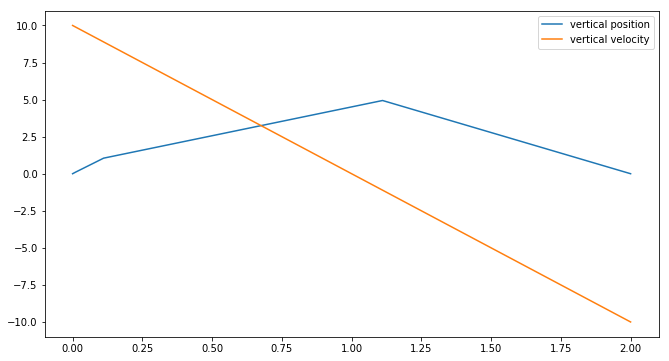

In [83]:
plt.plot(sol.t, sol.y[0], label="vertical position")
plt.plot(sol.t, sol.y[1], label="vertical velocity")
plt.legend();

Gosh, ain't that plot ugly, though! We can fix it with the `t_eval` parameter to `solve_ivp`, which forces calculations of the function at the prescribed times. We'll also add another event that calculates when the cannonball stops in mid-air:

[array([2.]), array([1.])]

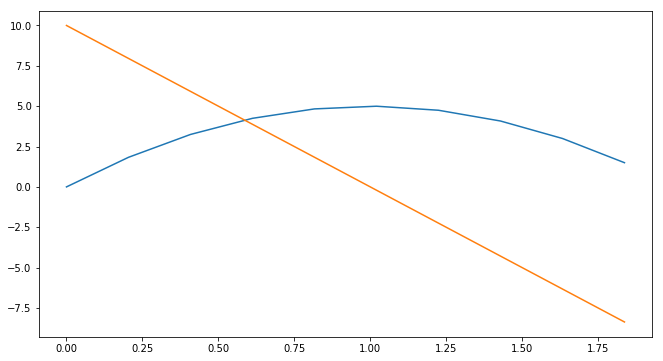

In [84]:
def zero_velocity(t, y):
    return y[1]

t = np.linspace(0, 10)
sol_t_eval = solve_ivp(upward_cannon,
                       [0, 10],
                       [0, 10],
                       events=[hit_ground, zero_velocity],
                       t_eval=t)
plt.plot(sol_t_eval.t, sol_t_eval.y[0])
plt.plot(sol_t_eval.t, sol_t_eval.y[1])
sol_t_eval.t_events

Of course, the first array of event times corresponds to hitting-the-ground-with-a-thud, and the second corresponds to stopping in midair. Notice how the trajectory seems to stop early, though:

In [85]:
sol_t_eval.t.max()

1.836734693877551

But that's just a case of having few (50 by default) points in our `linspace`:

1.9597989949748744

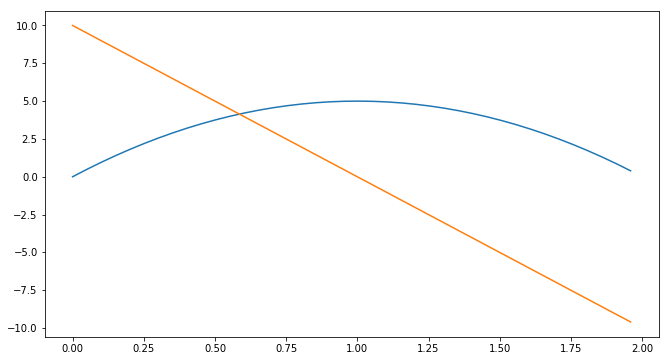

In [86]:
sol_t_eval_fixed = solve_ivp(upward_cannon,
                           [0, 10],
                           [0, 10],
                           events=[hit_ground, zero_velocity],
                           t_eval=np.linspace(0, 10, 200))
plt.plot(sol_t_eval_fixed.t, sol_t_eval_fixed.y[0])
plt.plot(sol_t_eval_fixed.t, sol_t_eval_fixed.y[1])
sol_t_eval_fixed.t.max()

Much better! And now, let's abandon this toy example and do something I've been putting off for a good while, now:

# Poincaré section of the Rossler attractor
[As seen on Wikipedia](https://en.wikipedia.org/wiki/R%C3%B6ssler_attractor#Definition) (and it is amazing that if you go to edit, you can just copypaste the LaTeX source), the Rossler system is defined by the following set of differential equations:
$$ \begin{cases}  \frac{dx}{dt} = -y - z \\ \frac{dy}{dt} = x + ay \\ \frac{dz}{dt} = b + z(x-c) \end{cases} $$

We'll take sample parameters from Wikipedia and set up the derivative function:

In [107]:
a=0.1
b=0.1
c=14
x_section = 10

def rossler(t, vector):
    x, y, z = vector   # for readability
    return [-y -z,
            x + a * y,
            b + z * (x - c),
           ]

What we want to do here is figure out a way to take a Poincaré (with whom I have a love-hate relationship, the love coming from his achievements and the hate coming from the é I have had to paste multiple times here) section. The way I think about **Poincaré sections** is that they're simply intersections of the trajectory of a system (the $\vec{y}(t) = (x(t), y(t), z(t)$ curve) with some particular surface. [Wikipedia has a more formal definition of those](https://en.wikipedia.org/wiki/Poincar%C3%A9_map).

We'll define our Poincaré section as $x = 10, \dot{x} < 0$. I picked $x=10$ simply because the plots came out nicely that way.
Unfortunately, `solve_ivp` at the time of writing does not seem to support saving values of the vector $\vec{y} = (x, y, z)$ at event times - it simply saves the times themselves. That's probably a future PR - but for now, we can hack that ourselves, given that we're just interested in collecting a bunch of points at $x \approx 10$:

In [109]:
events = []
def poincare(t, vector):
    x = vector[0]
    if np.isclose(x, x_section, rtol=1e-9, atol=1e-12):
        events.append((t, vector))
    return x - x_section
poincare.direction = -1    # decreasing x

sol = solve_ivp(rossler,
               [0, 500000],
               [-0.2, 0.2, 5.2],
               events=poincare)

In [127]:
len(sol.t_events[0])/len(events)

0.4678223495702006

Turns out we got about twice as many section events as we should have. This is reasonable - as the solver of the equation defined by `poincare(x,y,z) = 0` equation creeps closer and closer to a point where it's exactly satisfied, `poincare` is evaluated multiple times - and `events` gets multiple entries from each actual P-section. No matter! For most of our plots, this is going to be fine.

We'll plot the whole trajectory we got in glorious 3D, with the Poincaré section in orange:

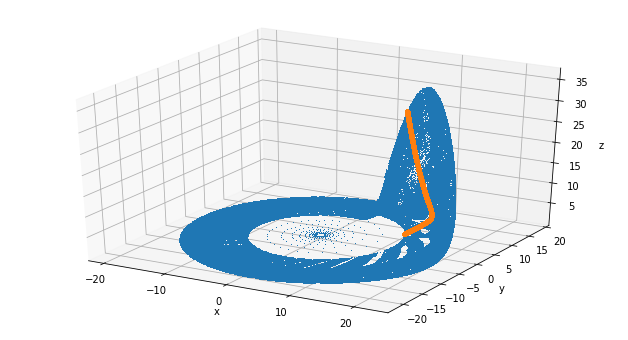

In [133]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2], ',')

vectors = np.array([e[1] for e in events])
t = np.array([e[0] for e in events])
x, y, z = vectors.T
ax.plot(x, y, z, ".")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

We'll take another picture from a different angle to show that this is indeed the Poincaré section we were looking for:

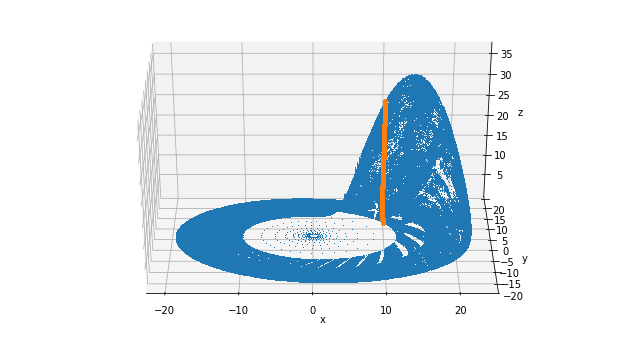

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, -90)
ax.plot(sol.y[0], sol.y[1], sol.y[2], ',')
ax.plot(x, y, z, ".")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z");

We can also plot simply $y(t)$:

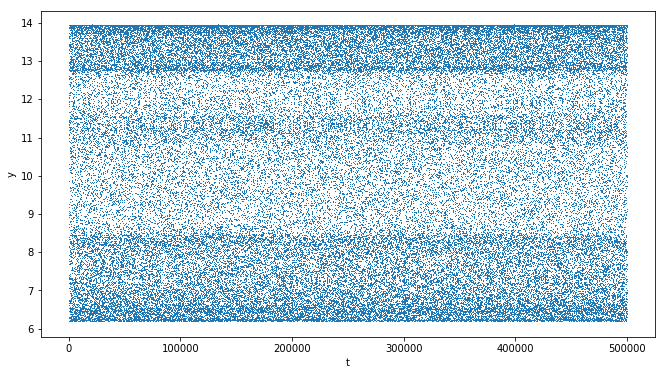

In [139]:
plt.plot(t, y, ",")
plt.xlabel("t")
plt.ylabel("y");

Which is of course rather unenlightening. What we would be ultimately interested in is a **Poincaré map** - a map of $y(t_{n+1})$ plotted against $y(t_n)$. This has many useful properties that I'm just beginning to learn about. Let's see what we get:

Text(0, 0.5, '$y(t_{n+1})$')

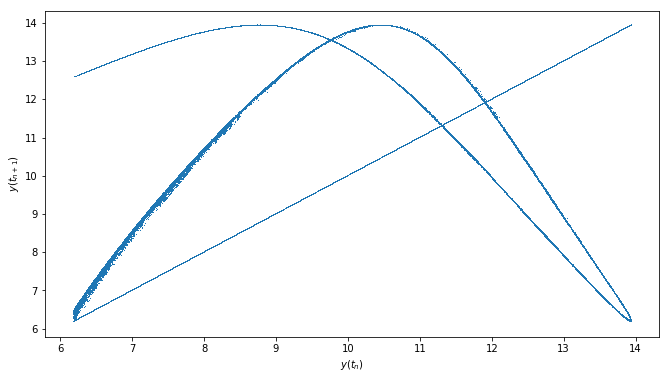

In [141]:
plt.plot(y[:-1], y[1:], ",")
plt.xlabel(r"$y(t_n)$")
plt.ylabel(r"$y(t_{n+1})$")

Notice that `","` passed to `plt.plot` draws a single pixel at each point's location. If you look closely, you can see something like a 3D-rotated peak of the Rossler attractor (it's sort of shaped like a U, except the open-ended lines are bent towards the left).

There is also a line corresponding to $y(t_n) = y(t_{n+1})$. This one is to be expected as an artifact of our faulty point-gathering method. Remember that we gathered about twice as many points as there were points located by `solve_ivp`? Well, this just shows that those twice-as-many-points are mostly pairs of adjacent points close to each other! To illustrate what I mean, let me calculate $|y(t_{n+1}) - y(t_n)|$ for each $t_n$ in the trajectory and plot a histogram of that:

Text(0.5, 0, '|y(t_n) = y(t_{n+1})|')

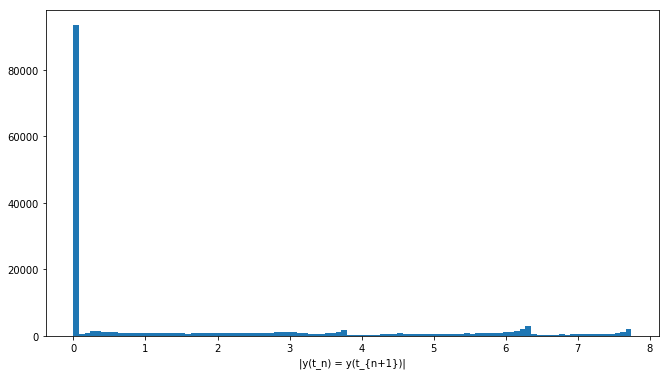

In [156]:
plt.hist(np.abs(np.diff(y)), bins=100)
plt.xlabel(r"|y(t_n) = y(t_{n+1})|")

That's about 100k points that didn't move much at all between two hits of the $x=10$ plane! That's clearly incorrect.

Hopefully I'll be able to provide an upgraded version of this solution in the future! For now... go try out `scipy.integrate.solve_ivp`!